In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

import glob
import os
import sys

from scipy import spatial

%matplotlib inline

states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

df=gpd.read_file('/glade/u/home/currierw/work/shape/crb/b9522000.shp')
df

,AREA,GAGE_NA_ID,STAID,SITEID,NAME,BASIN,MI2,MI2USA,geometry
0,6.197680e+11,9522000,09522000,9522000,"Colorado R at NIB, ab Morelos Dam, nr Andrade,CA",Colo,239292,238186,"POLYGON ((-108.19123 35.12274, -108.19174 35.1..."


In [2]:
def getFlist(dirName,baseOut,timeStarList):
    for i in range(0,len(timeStarList)):
        fileListTmp=sorted(glob.glob(dirName+'/'+baseOut+timeStarList[i]))
        if i > 0:
            fileList.extend(fileListTmp)
        else:
            fileList=fileListTmp        
    return fileList

# Upload ICAR

In [3]:
base       = '/glade/scratch/currierw/icar/crb/eraiLongNeg3mpNew/'
baseName   = ''

# Information related to the directory names in staggered icar runs
startDates = ['2000-09',    '2001-03',    '2001-09',   '2002-03',   '2002-09',   '2003-03',   '2003-09',   '2004-03']
endDates   = ['2001_04',    '2001_10',    '2002_04',   '2002_10',   '2003_04',   '2003_10',   '2004_04',   '2004_10']


fileStart = ['2000_10_01','2001_04_01','2001_10_01','2002_04_01','2002_10_01','2003_04_01','2003_10_01','2004_04_01']
fileEnd   = ['2001_03_31','2001_09_30','2002_03_31','2002_09_30','2003_03_31','2003_09_30','2004_03_31','2004_09_30']

    
dirName=base+baseName+startDates[0]+'_'+endDates[0]
fList=getFlist(dirName,'icar_out',['2000_10*','2000_11*','2000_12*'])
dsICAR=xr.open_mfdataset(fList,combine='by_coords',parallel=True)
dsICAR['lon']=(((dsICAR['lon'] + 180) % 360) - 180)

# Upload WRF 2d

In [76]:
wrfVariable='PREC_ACC_NC' # water vapor mixing ratio at the lowest model level
years=['2000','2001','2001','2001']
timeSpan=['200010-200012','200101-200103','200104-200106','200107-200109']
filePath='/gpfs/fs1/collections/rda/data/ds612.0/CTRL/'+years[0]
baseName='/wrf2d_d01_CTRL_'+wrfVariable+'_'+timeSpan[0]+'.nc'

dsWRF=xr.open_mfdataset(filePath+baseName,combine='by_coords',parallel=True)
dsWRF=dsWRF.resample(Time="3H").mean()

# dsWRFsub=dsWRF[wrfVariable].where((dsWRF.XLAT > lat_bnds[0]) & (dsWRF.XLAT < lat_bnds[1]) & (dsWRF.XLONG > lon_bnds[0]) & (dsWRF.XLONG < lon_bnds[1]), drop=True)


In [77]:
wrfVariable='QVAPOR' # water vapor mixing ratio at the lowest model level
years=['2000','2001','2001','2001']
timeSpan=['200010-200012','200101-200103','200104-200106','200107-200109']
filePath='/gpfs/fs1/collections/rda/data/ds612.0/CTRL/'+years[0]
baseName='/wrf2d_d01_CTRL_'+wrfVariable+'_'+timeSpan[0]+'.nc'

dsWRFqv=xr.open_mfdataset(filePath+baseName,combine='by_coords',parallel=True)
dsWRFqv=dsWRFqv.resample(Time="3H").mean()
# dsWRFsub=dsWRF[wrfVariable].where((dsWRF.XLAT > lat_bnds[0]) & (dsWRF.XLAT < lat_bnds[1]) & (dsWRF.XLONG > lon_bnds[0]) & (dsWRF.XLONG < lon_bnds[1]), drop=True)


In [ ]:
dsWRFconstant=xr.open_dataset('/gpfs/fs1/collections/rda/data/ds612.0/INVARIANT/RALconus4km_wrf_constants.nc')
dsWRFconstant['HGT'].plot(cmap='terrain',vmin=0)

# Upload WRF 3d

In [87]:
wrfVariable='QVAPOR' # water vapor mixing ratio at the lowest model level
years=['2000','2001','2001','2001']
timeRange=['200010*','200011*','200012*']


filePath='/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/'+years[0]
baseName='wrf3d_d01_CTRL_'+wrfVariable+'_'
fList=getFlist(filePath,baseName,timeRange)
dsWRFqv3d=xr.open_mfdataset(fList,combine='by_coords',parallel=True)
# dsWRFsub=dsWRFresample[wrfVariable].where((dsWRFresample.XLAT > lat_bnds[0]) & (dsWRFresample.XLAT < lat_bnds[1]) & \
#                                           (dsWRFresample.XLONG > lon_bnds[0]) & (dsWRFresample.XLONG < lon_bnds[1]), drop=True)

wrfVariable='QSNOW' # water vapor mixing ratio at the lowest model level
baseName='wrf3d_d01_CTRL_'+wrfVariable+'_'
fList=getFlist(filePath,baseName,timeRange)
dsWRFqs3d=xr.open_mfdataset(fList,combine='by_coords',parallel=True)

wrfVariable='QRAIN' # water vapor mixing ratio at the lowest model level
baseName='wrf3d_d01_CTRL_'+wrfVariable+'_'
fList=getFlist(filePath,baseName,timeRange)
dsWRFqr3d=xr.open_mfdataset(fList,combine='by_coords',parallel=True)


wrfVariable='Z' # water vapor mixing ratio at the lowest model level
baseName='wrf3d_d01_CTRL_'+wrfVariable+'_'
fList=getFlist(filePath,baseName,timeRange)
dsWRFz3d=xr.open_mfdataset(fList,combine='by_coords',parallel=True)


# Get lat lon indices for a dataset

In [16]:
def getLatLonIdxICAR(ds,phi):
    # Bottom left starting
    gridSpaceLon=ds['lon'][0,0]-ds['lon'][0,1] # difference in longitude
    gridSpaceLat=ds['lat'][0,0]-ds['lat'][1,0] # difference in latitude

    minDistance=np.abs([gridSpaceLon,gridSpaceLat]) # grid spacing
    gridSpace=np.min(minDistance)
    a2=(ds['lon'][0,0]-ds['lon'][0,-1]) * (ds['lon'][0,0]-ds['lon'][0,-1])
    b2=(ds['lat'][-1,0]-ds['lat'][0,0]) * (ds['lat'][-1,0]-ds['lat'][0,0]) 
    maxDistanceSearch=np.sqrt(a2+b2) - 3
    xlin = maxDistanceSearch*np.cos(phi)+ds['lon'][0,0] # X (easting) coordinate at end of line direction phi
    ylin = maxDistanceSearch*np.sin(phi)+ds['lat'][0,0] # Y (northing) coordinate at end of line direction phi

    # xVec=np.arange(ds['lon'][0,0].values,xlin.values,gridSpace)
    # yVec=np.arange(ds['lat'][0,0].values,ylin.values,gridSpace)

    xVec=np.arange(ds['lon'][0,0].values,xlin.values,gridSpace)
    yVec=np.arange(ds['lat'][0,0].values,ylin.values,gridSpace)

    numPoints=np.max([len(xVec),len(yVec)])
    numPoints

    xVec2=np.linspace(ds['lon'][0,0].values,xlin.values,numPoints)
    yVec2=np.linspace(ds['lat'][0,0].values,ylin.values,numPoints)

    dsZ=ds['z'][0,0,:,:]
    pixel_center_points = np.stack((dsZ.lat.values.flatten(), dsZ.lon.values.flatten()), axis=-1)
    tree = spatial.KDTree(pixel_center_points)

    pixel_coords_list = [None] * len(xVec2)
    lonArray      = np.ndarray(shape=len(xVec2),dtype=float,order='F')
    latArray      = np.ndarray(shape=len(xVec2),dtype=float,order='F')

    for i in range(0,len(xVec2)):
        searchCoords = (yVec2[i],xVec2[i])
        distance, index = tree.query(searchCoords)
        pixel_coords = np.unravel_index(index, dsZ.shape)
        pixel_coords_list[i]=[pixel_coords[0],pixel_coords[1]]
        lonArray[i]=dsZ['lon'][pixel_coords].values
        latArray[i]=dsZ['lat'][pixel_coords].values
    
    return lonArray, latArray, pixel_coords_list

In [17]:
phi=np.pi/4
lonArrayICAR,latArrayICAR,pixel_coords_list_ICAR=getLatLonIdxICAR(dsICAR,phi)

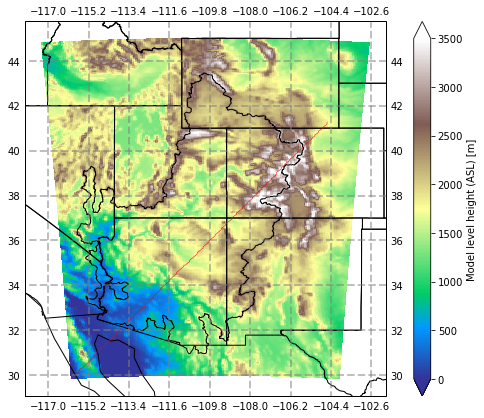

In [161]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

x = [i[0] for i in pixel_coords_list_ICAR]
y = [i[1] for i in pixel_coords_list_ICAR]
ax = plt.axes((0,0,1.3,1.3),projection=ccrs.PlateCarree())

dsICAR['z'][0,0,:,:].plot(x='lon',y='lat',cmap='terrain',vmin=0,vmax=3500)
for i in range(0,len(pixel_coords_list_ICAR)):
    plt.plot(dsICAR['lon'][x[i],y[i]],dsICAR['lat'][x[i],y[i]],'ro',linewidth=3)
# plt.plot(lonArrayICAR,latArrayICAR,'r-',linewidth=0.5)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.set_title('')
ax.add_geometries(states_gdf.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black')
ax.add_geometries(df.geometry, crs = ccrs.PlateCarree(),facecolor='none', edgecolor='black',linewidth =1)

# Get WRF transect

In [29]:
def getLatLonIdxWRF(ds,lonArrayIn,latArrayIn):
    xVec2=lonArrayIn
    yVec2=latArrayIn
    
    dsZ=ds['HGT'][0,:,:]
    pixel_center_points = np.stack((dsZ['XLAT'].values.flatten(), dsZ['XLONG'].values.flatten()), axis=-1)
    tree = spatial.KDTree(pixel_center_points)

    pixel_coords_list = [None] * len(xVec2)
    lonArray      = np.ndarray(shape=len(xVec2),dtype=float,order='F')
    latArray      = np.ndarray(shape=len(xVec2),dtype=float,order='F')

    for i in range(0,len(xVec2)):
        searchCoords = (yVec2[i],xVec2[i])
        distance, index = tree.query(searchCoords)
        pixel_coords = np.unravel_index(index, dsZ.shape)
        pixel_coords_list[i]=[pixel_coords[0],pixel_coords[1]]
        lonArray[i]=dsZ['XLONG'][pixel_coords].values
        latArray[i]=dsZ['XLAT'][pixel_coords].values
    
    return lonArray, latArray, pixel_coords_list

lonArrayWRF,latArrayWRF,pixel_coords_list_WRF=getLatLonIdxWRF(dsWRFconstant,lonArrayICAR,latArrayICAR)

In [ ]:
import matplotlib.image as mgimg
from matplotlib import animation

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# #create empty list for images 
# myimages = []

## ICAR Dimensions
time,lev,lat,lon=dsICAR['qv'].shape
lonMatICAR=np.tile(lonArrayICAR,(lev,1))

## WRF Dimensions
timeWRF,levWRF,latWRF,lonWRF=dsWRFqr3d['QRAIN'].shape
levWRF=25
lonMatWRF=np.tile(lonArrayWRF,(levWRF,1))

times=pd.date_range('2000-10-15','2000-12-31',freq='3H')

for tt in range(0,len(times)):

    # ICAR Z array
    if tt == 0:
        zArray=np.ndarray(shape=(lev,len(lonArrayICAR)), dtype=float, order='F')
        for i in range(0,len(lonArrayICAR)):
            zArray[:,i]=dsICAR['z'][0,:,pixel_coords_list_ICAR[i][0],pixel_coords_list_ICAR[i][1]].values

    # WRF Z array
    if tt == 0:
        zArrayWRF=np.ndarray(shape=(levWRF,len(lonArrayWRF)), dtype=float, order='F')
        for i in range(0,len(lonArrayWRF)):
            zArrayWRF[:,i]=dsWRFz3d['Z'][0,:levWRF,pixel_coords_list_WRF[i][0],pixel_coords_list_WRF[i][1]].values            

    # Set Up Subplots ##############################
    fig = plt.figure(figsize=(30, 20))
    heights = [1, 1, 1, 1.5]
    widths = [0.5,0.5, 0.025, 0.5,0.5, 0.025]
    nrows = 4
    ncols = 6
    spec = fig.add_gridspec(ncols=ncols, nrows=nrows,
                            width_ratios=widths,
                            height_ratios=heights,
                            wspace=0.25, hspace=0.2)

    ax_maps = []
    for row in range(nrows-1):
        ax_maps.append(fig.add_subplot(spec[row, 0:-4]))
    for row in range(nrows-1):
        ax_maps.append(fig.add_subplot(spec[row, 3:-1]))
    ax_cbar0 = fig.add_subplot(spec[0, 2])
    ax_cbar1 = fig.add_subplot(spec[1, 2])
    ax_cbar2 = fig.add_subplot(spec[2, 2])

    ax_cbar3 = fig.add_subplot(spec[0, 5])
    ax_cbar4 = fig.add_subplot(spec[1, 5])
    ax_cbar5 = fig.add_subplot(spec[2, 5])
    # ax_cbar3 = fig.add_subplot(spec[3, 1])
    # ax_cbar4 = fig.add_subplot(spec[4, 1])

    ax_maps.append(fig.add_subplot(spec[-1, 0]))
    ax_maps.append(fig.add_subplot(spec[-1, 1]))
    ax_maps.append(fig.add_subplot(spec[-1, 3]))
    ax_maps.append(fig.add_subplot(spec[-1, 4]))
    ################################################
    
    timestring = times[tt].strftime('%Y.%m.%d-%H')
    timestring
    
    ###### ICAR ####################################
    
    # Water Vapor Mixing Ratio
    ax = ax_maps[0]   
    qvArray=np.ndarray(shape=(lev,len(lonArrayICAR)), dtype=float, order='F')
    dsSel=dsICAR['qv'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    for i in range(0,len(lonArrayICAR)):
        qvArray[:,i]=dsSel[0,:,pixel_coords_list_ICAR[i][0],pixel_coords_list_ICAR[i][1]].values
    im = ax.pcolormesh(lonMatICAR, zArray, qvArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.012)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar0, extend='both')
    ax_cbar0.yaxis.set_ticks_position('left')
    ax.set_title('ICAR '+timestring+' qv= Water Wapor Mixing Ratio')

    # Cloud Liquid Water Content
    ax = ax_maps[1]
    # (time, lev, lat_y, lon_x)
    dsSel=dsICAR['qc'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    qcArray=np.ndarray(shape=(lev,len(lonArrayICAR)), dtype=float, order='F')
    for i in range(0,len(lonArrayICAR)):
        qcArray[:,i]=dsSel[0,:,pixel_coords_list_ICAR[i][0],pixel_coords_list_ICAR[i][1]].values
    im = ax.pcolormesh(lonMatICAR, zArray, qcArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.0005)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar1, extend='both')
    ax_cbar1.yaxis.set_ticks_position('left')
    ax.set_title('ICAR '+timestring+' qc = Cloud liquid water content')

    # Snow Content
    ax = ax_maps[2]
    dsSel=dsICAR['qs'].sel(time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    qsArray=np.ndarray(shape=(lev,len(lonArrayICAR)), dtype=float, order='F')
    for i in range(0,len(lonArrayICAR)):
        qsArray[:,i]=dsSel[0,:,pixel_coords_list_ICAR[i][0],pixel_coords_list_ICAR[i][1]].values    
    im = ax.pcolormesh(lonMatICAR, zArray, qsArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.0005)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar2, extend='both')
    ax_cbar2.yaxis.set_ticks_position('left')
    ax.set_title('ICAR '+timestring+' qs= Snow ice content')
    
    ###### WRF ####################################
    # Only the first thirty levels
    
    # Water Vapor Mixing Ratio
    ax = ax_maps[3]   
    qvArray=np.ndarray(shape=(levWRF,len(lonArrayWRF)), dtype=float, order='F')
    dsSel=dsWRFqv3d['QVAPOR'].sel(Time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    for i in range(0,len(lonArrayWRF)):
        qvArray[:,i]=dsSel[:levWRF,pixel_coords_list_WRF[i][0],pixel_coords_list_WRF[i][1]].values
    im = ax.pcolormesh(lonMatWRF, zArrayWRF, qvArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.012)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar3, extend='both')
    ax_cbar3.yaxis.set_ticks_position('left')
    ax.set_title('WRF '+timestring+' qv= Water Wapor Mixing Ratio')

    # Cloud Liquid Water Content
    ax = ax_maps[4]
    # (time, lev, lat_y, lon_x)
    dsSel=dsWRFqr3d['QRAIN'].sel(Time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    qcArray=np.ndarray(shape=(levWRF,len(lonArrayWRF)), dtype=float, order='F')
    for i in range(0,len(lonArrayWRF)):
        qcArray[:,i]=dsSel[:levWRF,pixel_coords_list_WRF[i][0],pixel_coords_list_WRF[i][1]].values
    im = ax.pcolormesh(lonMatWRF, zArrayWRF, qcArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.0005)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar4, extend='both')
    ax_cbar4.yaxis.set_ticks_position('left')
    ax.set_title('WRF'+timestring+' qc = Cloud liquid water content')

    # Snow Content
    ax = ax_maps[5]
    dsSel=dsWRFqs3d['QSNOW'].sel(Time=times[tt].strftime('%Y-%m-%d %H%M%S'))
    qsArray=np.ndarray(shape=(levWRF,len(lonArrayWRF)), dtype=float, order='F')
    for i in range(0,len(lonArrayWRF)):
        qsArray[:,i]=dsSel[:levWRF,pixel_coords_list_WRF[i][0],pixel_coords_list_WRF[i][1]].values    
    im = ax.pcolormesh(lonMatWRF, zArrayWRF, qsArray,
                           cmap=plt.get_cmap('viridis'),
                      linewidth=0,
                      rasterized=True,
                      vmin=0,vmax=0.0005)
    ax.set_ylabel('Height (m)')
    plt.colorbar(im, cax=ax_cbar5, extend='both')
    ax_cbar5.yaxis.set_ticks_position('left')
    ax.set_title('WRF '+timestring+' qs= Snow ice content')
    
    #################################################################################################################
    ###### Two-dimensional plots ####################################################################################
    #################################################################################################################
    
    ############# ICAR #################################
    ax = plt.axes(ax_maps[6],projection=ccrs.PlateCarree())

    if tt>0:
        dsICARslice=dsICAR['rain'].sel(time=slice(times[0],times[tt]))
        dsICARAccum=dsICARslice[-1,:,:]-dsICARslice[0,:,:]
    else:
        dsICARAccum=dsICAR['rain'].sel(time=times[tt].strftime('%Y-%m-%d %H:%M:%S'))
        dsICARAccum=dsICARAccum[0,:,:]
        
    dsICARAccum.plot(x='lon',y='lat',cmap='Blues',vmin=0,vmax=400,cbar_kwargs={'label': 'precipitation [mm]'})
    ax.set_title('ICAR 6km '+times[tt].strftime('%Y-%m-%d %H:%M:%S'))
    ax.set_xlim(-117,-103),ax.set_ylim(29.5,45.5)
    states_gdf.geometry.plot(facecolor='none', edgecolor='black',ax=ax)
    df.geometry.plot(facecolor='none', edgecolor='black',linewidth=0.5,ax=ax)
    plt.plot(lonArrayICAR,latArrayICAR,'r-',linewidth=0.5)

    
    # ############
    ax = plt.axes(ax_maps[7],projection=ccrs.PlateCarree())
    dsICARsel=dsICAR['qv'].sel(time=times[tt].strftime('%Y-%m-%d %H:%M:%S'))
    dsICARsel[0,0,:,:].plot(x='lon',y='lat',cmap='Blues',vmin=0,vmax=0.02,cbar_kwargs={'label': 'Mixing Ratio [kg / kg]'})
    ax.set_title('ICAR 6km '+times[tt].strftime('%Y-%m-%d %H:%M:%S'))
    ax.set_xlim(-117,-103),ax.set_ylim(29.5,45.5)
    states_gdf.geometry.plot(facecolor='none', edgecolor='black',ax=ax)
    df.geometry.plot(facecolor='none', edgecolor='black',linewidth=0.5,ax=ax)
    plt.plot(lonArrayICAR,latArrayICAR,'r-',linewidth=0.5)

    
    ############# WRF ##################################
    ax = plt.axes(ax_maps[8],projection=ccrs.PlateCarree()) 
    
    if tt>0:
        dsWRFsel=dsWRF['PREC_ACC_NC'].sel(Time=slice(times[0],times[tt]))
        dsWRFmonAccum=dsWRFsel.sum(dim='Time')
    else:
        dsWRFmonAccum=dsWRF['PREC_ACC_NC'].sel(Time=times[tt].strftime('%Y-%m-%d %H:%M:%S'))
        
    dsWRFmonAccum.plot(x='XLONG',y='XLAT',cmap='Blues',vmin=0,vmax=400,cbar_kwargs={'label': 'precipitation [mm]'})
    ax.set_title('WRF 4km '+times[tt].strftime('%Y-%m-%d %H:%M:%S'))
    ax.set_xlim(-117,-103),ax.set_ylim(29.5,45.5)
    states_gdf.geometry.plot(facecolor='none', edgecolor='black',ax=ax)
    df.geometry.plot(facecolor='none', edgecolor='black',linewidth=0.5,ax=ax)
    plt.plot(lonArrayICAR,latArrayICAR,'r-',linewidth=0.5)
    
    ax = plt.axes(ax_maps[9],projection=ccrs.PlateCarree()) 
    
    dsWRFsel=dsWRFqv['QVAPOR'].sel(Time=times[tt].strftime('%Y-%m-%d %H:%M:%S'))
    dsWRFsel.plot(x='XLONG',y='XLAT',cmap='Blues',vmin=0,vmax=0.02,cbar_kwargs={'label': 'Mixing Ratio [kg / kg]'})
    ax.set_title('WRF 4km '+times[tt].strftime('%Y-%m-%d %H:%M:%S'))
    ax.set_xlim(-117,-103),ax.set_ylim(29.5,45.5)
    states_gdf.geometry.plot(facecolor='none', edgecolor='black',ax=ax)
    df.geometry.plot(facecolor='none', edgecolor='black',linewidth=0.5,ax=ax)
    plt.plot(lonArrayICAR,latArrayICAR,'r-',linewidth=0.5)


    if tt==0:
        os.system('mkdir -p crossSection')
    
    fig.savefig('crossSection/delete'+str(tt).zfill(4)+'.png', dpi=300, bbox_inches='tight')
    plt.close(fig=fig)

# Make a video of the output .png's
# os.system('module load ffmpeg')
# os.system('ffmpeg -r 15 -pattern_type glob -i '*.png' -vcodec libx264 -vf scale=1280:-2,format=yuv420p movie.mp4')